# Projet IPEO

### Data loading

In [11]:
import os
import random
from collections import defaultdict

import torch
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
import matplotlib.pyplot as plt
import numpy as np

Device utilisé : cpu
Classes : ['damage', 'no_damage']
Nombre d'images (train) : 19000
Nombre d'images (val) : 2000
Nombre d'images (test) : 2000


/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/hurricane/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environm

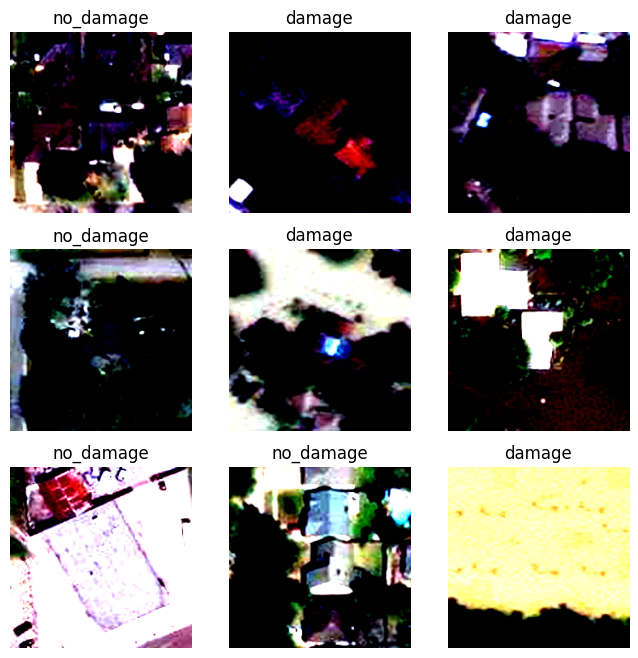

In [12]:
base_dir = "ipeo_hurricane_for_students"

mean = torch.tensor([0.35233327746391296, 0.3841049373149872, 0.28581997752189636])
std = torch.tensor([0.1441640853881836, 0.1249275803565979, 0.12649250030517578])

normalize = T.Normalize(mean, std)

default_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])


train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=default_transform)
val_ds   = datasets.ImageFolder(os.path.join(base_dir, "validation"), transform=default_transform)
test_ds  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=default_transform)

# Détection du device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)


# Ajustements DataLoader pour CPU (si pas de GPU) : réduire batch_size si besoin, num_workers=0 sur macOS (2 dans le cours)
# à voir si on garde ça comme ça
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, num_workers=2, pin_memory=False)

print("Classes :", train_ds.classes)
print("Nombre d'images (train) :", len(train_ds))
print("Nombre d'images (val) :", len(val_ds))
print("Nombre d'images (test) :", len(test_ds))

def show_batch(loader):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for img, label, ax in zip(images[:9], labels[:9], axes.flat):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(train_ds.classes[label])
        ax.axis("off")
    plt.show()

show_batch(train_loader)

### Model loading

In [13]:
from torchvision.models import resnet34, mobilenet_v3_small


# load a resnet34 with 21 classes and move to device
model_resnet = resnet34(num_classes=21).to(device)
model_resnet

# load a mobilnet_v3_small with 21 classes and move to device
model_mobilenet = mobilenet_v3_small(num_classes=21).to(device)
model_mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Loss function

In [14]:
# Define the loss function
criterion = CrossEntropyLoss()

### Optimizer

In [15]:
from torch.optim import SGD

learning_rate = 0.01

optimizer_resnet = SGD(model_resnet.parameters(),lr=learning_rate)
optimizer_mobilenet = SGD(model_mobilenet.parameters(),lr=learning_rate)

### Training step

In [16]:
import torch.nn.functional as F

def training_step(batch, model, optimizer, device):
    model.train()
    optimizer.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)
    loss = criterion(y_hat, y)

    loss.backward()
    optimizer.step()

    preds = y_hat.argmax(1).cpu().detach().numpy()
    gt = y.cpu().detach().numpy()
    accuracy = (preds == gt).mean()

    return loss.item(), float(accuracy)


### Training and validating over the full batch

In [17]:
import numpy as np

def train_epoch(train_dl, model, optimizer, device):

    # collect some statistics
    losses, accuracies = [], []
    total_batches = len(train_dl)
    print(f"Training: {total_batches} batches to process")

    for batch_idx, batch in enumerate(train_dl, 1):
        loss, accuracy = training_step(batch, model, optimizer, device)

        # append statistics (loss is a float already)
        losses.append(loss)
        accuracies.append(accuracy)
        
        # Print progress every 10 batches
        if batch_idx % 10 == 0 or batch_idx == total_batches:
            print(f"  Batch {batch_idx}/{total_batches} - loss: {loss:.4f}, acc: {accuracy*100:.2f}%")

    # protections si listes vides
    if len(losses) == 0:
        return 0.0, 0.0

    # return averaged losses and accuracies
    return float(np.mean(losses)), float(np.mean(accuracies))


def validate_epoch(val_dl, model, device):
    """Évalue le modèle sur l'ensemble de validation (sans backprop)."""
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():  # pas de gradient pour la validation
        for batch in val_dl:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = y_hat.argmax(1).cpu().detach().numpy()
            gt = y.cpu().detach().numpy()
            accuracy = (preds == gt).mean()

            losses.append(loss.item())
            accuracies.append(accuracy)

    if len(losses) == 0:
        return 0.0, 0.0

    return float(np.mean(losses)), float(np.mean(accuracies))

In [18]:
num_epochs = 30
import os
import json

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Vérifier si les modèles ET les stats existent
models_exist = (os.path.exists("models/mobilenet_final.pth") and 
                os.path.exists("models/resnet_final.pth") and 
                os.path.exists("models/stats.json"))

if models_exist:
    # Charger les modèles (map_location pour compatibilité CPU/GPU)
    model_mobilenet.load_state_dict(torch.load("models/mobilenet_final.pth", map_location=device))
    model_resnet.load_state_dict(torch.load("models/resnet_final.pth", map_location=device))
    print("✅ MobileNet loaded from models/mobilenet_final.pth")
    print("✅ ResNet loaded from models/resnet_final.pth")
    
    # Charger les stats
    with open("models/stats.json", "r") as f:
        saved_stats = json.load(f)
        stats_mobilenet = saved_stats["mobilenet"]
        stats_resnet = saved_stats["resnet"]
    print("✅ Stats loaded from models/stats.json")
    print("\n⏭️ TRAINING SKIPPED - using pre-trained models and stats")
    train_models = False
else:
    print("🔄 Starting training (models or stats not found)...")
    train_models = True

# ENTRAÎNER SEULEMENT SI LES MODÈLES N'EXISTENT PAS
if train_models:
    stats_mobilenet = []
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"MOBILENET - Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        trainloss_mobilenet, trainaccuracy_mobilenet = train_epoch(train_loader, model_mobilenet, optimizer_mobilenet, device)
        valloss_mobilenet, valaccuracy_mobilenet = validate_epoch(val_loader, model_mobilenet, device)

        print(f"epoch {epoch}; trainloss {trainloss_mobilenet:.4f}, train accuracy {trainaccuracy_mobilenet*100:.2f}% | valloss {valloss_mobilenet:.4f}, val accuracy {valaccuracy_mobilenet*100:.2f}%")

        stats_mobilenet.append({
            "trainloss": float(trainloss_mobilenet),
            "trainaccuracy": float(trainaccuracy_mobilenet),
            "valloss": float(valloss_mobilenet),
            "valaccuracy": float(valaccuracy_mobilenet),
            "epoch": epoch
        })

    # Save Mobilenet model after training
    torch.save(model_mobilenet.state_dict(), "models/mobilenet_final.pth")
    print("✅ Mobilenet model saved to models/mobilenet_final.pth")

    stats_resnet = []
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"RESNET - Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")
        trainloss_resnet, trainaccuracy_resnet = train_epoch(train_loader, model_resnet, optimizer_resnet, device)
        valloss_resnet, valaccuracy_resnet = validate_epoch(val_loader, model_resnet, device)

        print(f"epoch {epoch}; trainloss {trainloss_resnet:.4f}, train accuracy {trainaccuracy_resnet*100:.2f}% | valloss {valloss_resnet:.4f}, val accuracy {valaccuracy_resnet*100:.2f}%")

        stats_resnet.append({
            "trainloss": float(trainloss_resnet),
            "trainaccuracy": float(trainaccuracy_resnet),
            "valloss": float(valloss_resnet),
            "valaccuracy": float(valaccuracy_resnet),
            "epoch": epoch
        })

    # Save Resnet model after training
    torch.save(model_resnet.state_dict(), "models/resnet_final.pth")
    print("✅ Resnet model saved to models/resnet_final.pth")
    
    # Save stats as JSON
    with open("models/stats.json", "w") as f:
        json.dump({"mobilenet": stats_mobilenet, "resnet": stats_resnet}, f)
    print("✅ Stats saved to models/stats.json")
else:
    print("\n⏭️ TRAINING SKIPPED - using pre-trained models and stats")

✅ MobileNet loaded from models/mobilenet_final.pth
✅ ResNet loaded from models/resnet_final.pth
✅ Stats loaded from models/stats.json

⏭️ TRAINING SKIPPED - using pre-trained models and stats

⏭️ TRAINING SKIPPED - using pre-trained models and stats


/var/folders/4h/p7pm5jv5159ftt0l8h_6772r0000gn/T/ipykernel_8297/623730146.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mobilenet.load_state_dict(torch.load("mo

✅ MobileNet graph saved to outputs/mobilenet_training_curves.png


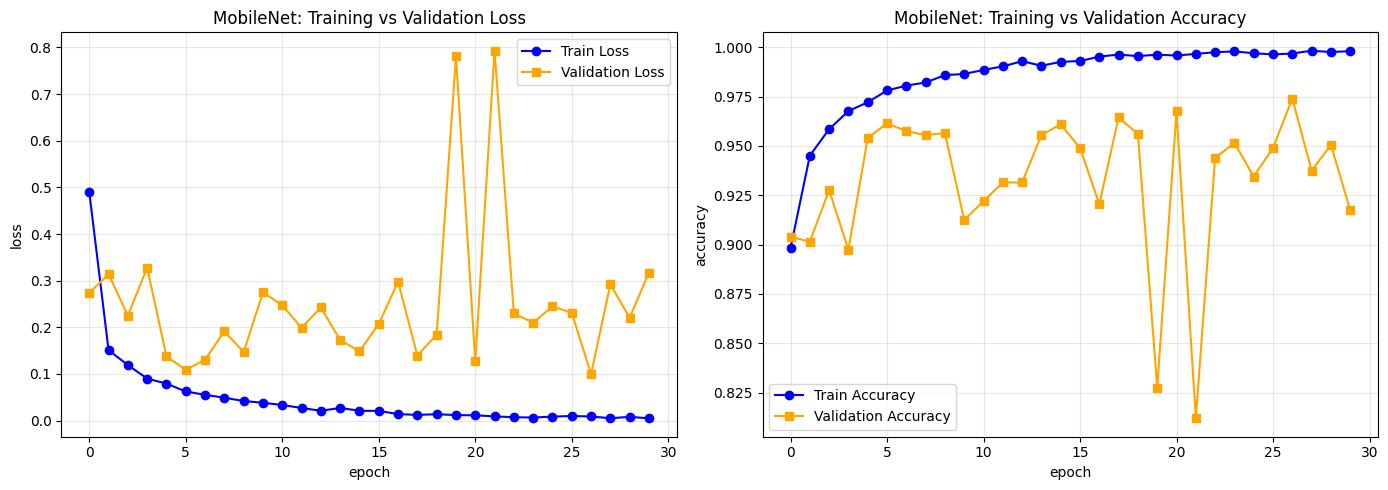

In [19]:
trainlosses = np.array([stat["trainloss"] for stat in stats_mobilenet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_mobilenet])
vallosses = np.array([stat["valloss"] for stat in stats_mobilenet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_mobilenet])
epochs = np.array([stat["epoch"] for stat in stats_mobilenet])
# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("MobileNet: Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("MobileNet: Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("outputs/mobilenet_training_curves.png", dpi=150, bbox_inches='tight')
print("✅ MobileNet graph saved to outputs/mobilenet_training_curves.png")
plt.show()


✅ ResNet graph saved to outputs/resnet_training_curves.png


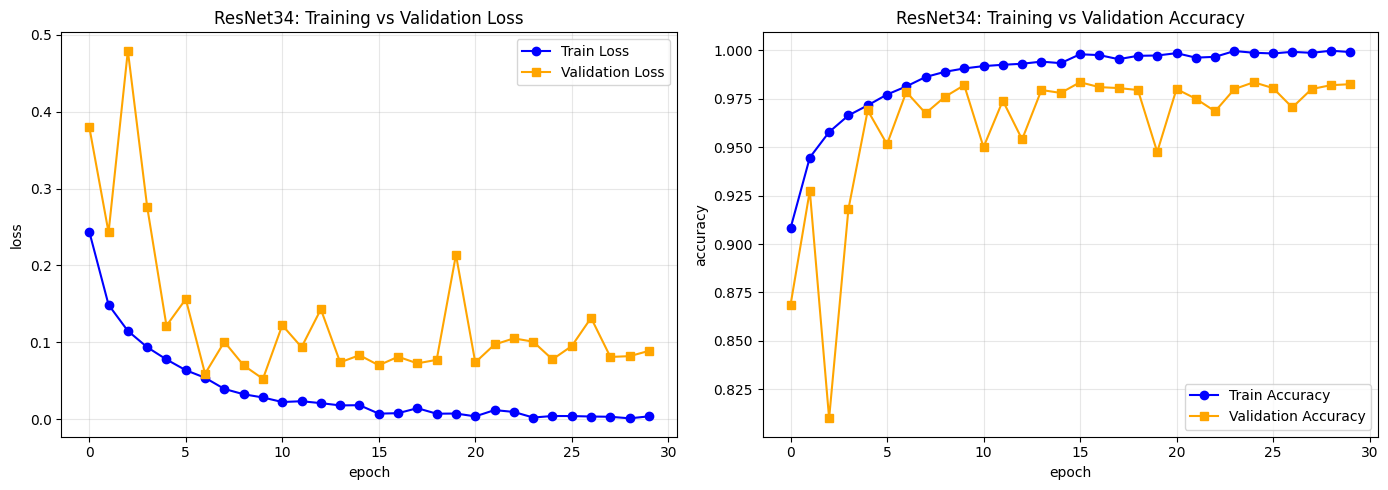

In [20]:
trainlosses = np.array([stat["trainloss"] for stat in stats_resnet])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats_resnet])
vallosses = np.array([stat["valloss"] for stat in stats_resnet])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats_resnet])
epochs = np.array([stat["epoch"] for stat in stats_resnet])
# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("ResNet34: Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("ResNet34: Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("outputs/resnet_training_curves.png", dpi=150, bbox_inches='tight')
print("✅ ResNet graph saved to outputs/resnet_training_curves.png")
plt.show()
